<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/MPI_Data_Base_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

!unzip downloaded_file.zip

# Validate

In [ ]:
import os
import glob
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Patch
from IPython.display import HTML
from google.colab import files

class VolumeProcessor:
    def __init__(self, raw_base_dir, seg_base_dir, bbox_name, excel_file):
        self.raw_base_dir = raw_base_dir
        self.seg_base_dir = seg_base_dir
        self.bbox_name = bbox_name
        self.excel_file = excel_file
        self.raw_vol = None
        self.seg_vol = None
        self.synapse_data = None

    def load_volume_data(self, max_slices=None):
        raw_dir = os.path.join(self.raw_base_dir, self.bbox_name)
        seg_dir = os.path.join(self.seg_base_dir, self.bbox_name)

        raw_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
        seg_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

        if max_slices:
            raw_files = raw_files[:max_slices]
            seg_files = seg_files[:max_slices]

        assert len(raw_files) == len(seg_files), "Number of raw and segmentation files do not match."

        self.raw_vol = np.stack([imageio.imread(f) for f in raw_files], axis=0)
        self.seg_vol = np.stack([imageio.imread(f).astype(np.uint32) for f in seg_files], axis=0)

    def load_synapse_data(self):
        self.synapse_data = pd.read_excel(self.excel_file)

    def create_segment_masks(self, side1_coord, side2_coord):
        x1, y1, z1 = map(int, side1_coord)
        x2, y2, z2 = map(int, side2_coord)

        seg_id_1 = self.seg_vol[z1, y1, x1]
        seg_id_2 = self.seg_vol[z2, y2, x2]

        mask_1 = (self.seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(self.seg_vol, dtype=bool)
        mask_2 = (self.seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(self.seg_vol, dtype=bool)
        return mask_1, mask_2

    def process_synapses(self, start_idx, end_idx, subvolume_size=80):
        half_size = subvolume_size // 2

        for idx in range(start_idx, end_idx):
            syn_info = self.synapse_data.iloc[idx]

            central_coord = (
                int(syn_info['central_coord_1']),
                int(syn_info['central_coord_2']),
                int(syn_info['central_coord_3'])
            )

            side1_coord = (
                int(syn_info['side_1_coord_1']),
                int(syn_info['side_1_coord_2']),
                int(syn_info['side_1_coord_3'])
            )

            side2_coord = (
                int(syn_info['side_2_coord_1']),
                int(syn_info['side_2_coord_2']),
                int(syn_info['side_2_coord_3'])
            )

            mask_1_full, mask_2_full = self.create_segment_masks(side1_coord, side2_coord)

            cx, cy, cz = central_coord

            x_start, x_end = max(cx - half_size, 0), min(cx + half_size, self.raw_vol.shape[2])
            y_start, y_end = max(cy - half_size, 0), min(cy + half_size, self.raw_vol.shape[1])
            z_start, z_end = max(cz - half_size, 0), min(cz + half_size, self.raw_vol.shape[0])

            sub_raw = self.raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
            sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
            sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

            self._generate_gif(sub_raw, sub_mask_1, sub_mask_2, syn_info, z_start)

    def _generate_gif(self, sub_raw, sub_mask_1, sub_mask_2, syn_info, z_start):
        fig, ax = plt.subplots(figsize=(5, 5))
        im = ax.imshow(sub_raw[0], cmap='gray', interpolation='nearest')
        ax.axis('off')

        legend_patches = [
            Patch(facecolor='red', edgecolor='red', label='Side 1'),
            Patch(facecolor='blue', edgecolor='blue', label='Side 2')
        ]
        ax.legend(handles=legend_patches, loc='upper right', frameon=True)

        def update(frame):
            overlay = np.stack([sub_raw[frame]] * 3, axis=-1).astype(float)

            overlay[sub_mask_1[frame]] = overlay[sub_mask_1[frame]] * 0.7 + np.array([255, 0, 0]) * 0.3
            overlay[sub_mask_2[frame]] = overlay[sub_mask_2[frame]] * 0.7 + np.array([0, 0, 255]) * 0.3

            overlay = np.clip(overlay, 0, 255).astype(np.uint8)
            ax.set_title(f"{syn_info['Var1']} - Z: {z_start + frame}")
            im.set_data(overlay)
            return [im]

        ani = animation.FuncAnimation(fig, update, frames=sub_raw.shape[0], interval=100, blit=True)

        gif_filename = f"{syn_info['Var1']}.gif"
        ani.save(gif_filename, writer='pillow', fps=10)
        plt.close(fig)
        print(f"Saved: {gif_filename}")
        # files.download(gif_filename)

raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_name = 'bbox1'
excel_file = f'{bbox_name}.xlsx'

processor = VolumeProcessor(raw_base_dir, seg_base_dir, bbox_name, excel_file)
processor.load_volume_data()
processor.load_synapse_data()
processor.process_synapses(start_idx=15, end_idx=26)


<ipython-input-5-f2c9154851e6>:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  self.raw_vol = np.stack([imageio.imread(f) for f in raw_files], axis=0)
<ipython-input-5-f2c9154851e6>:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  self.seg_vol = np.stack([imageio.imread(f).astype(np.uint32) for f in seg_files], axis=0)


Saved: non_spine_synapse_047.gif
Saved: non_spine_synapse_046.gif
Saved: non_spine_synapse_045.gif
Saved: non_spine_synapse_044.gif
Saved: non_spine_synapse_040.gif
Saved: non_spine_synapse_038.gif
Saved: non_spine_synapse_037.gif
Saved: non_spine_synapse_036.gif
Saved: non_spine_synapse_035.gif
Saved: non_spine_synapse_034.gif
Saved: non_spine_synapse_033.gif


# Data Loader

<ipython-input-2-0d8c3477742a>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  raw_slices = [imageio.imread(f) for f in raw_tif_files]
<ipython-input-2-0d8c3477742a>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  seg_slices = [imageio.imread(f).astype(np.uint32) for f in seg_tif_files]


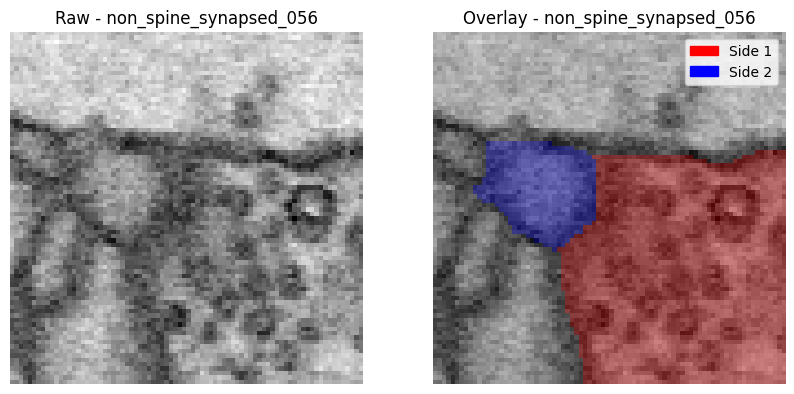

In [2]:
import pandas as pd
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from matplotlib.patches import Patch

raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_name = 'bbox1'
excel_file = f'{bbox_name}.xlsx'

def load_bbox_data(bbox_name, max_slices=None):
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), "Raw and segmentation file counts do not match."

    raw_slices = [imageio.imread(f) for f in raw_tif_files]
    seg_slices = [imageio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # shape (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # shape (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

class SynapseDataset(Dataset):
    def __init__(self, raw_vol, seg_vol, synapse_df, subvol_size=80):
        self.raw_vol = raw_vol
        self.seg_vol = seg_vol
        self.synapse_df = synapse_df
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        central_coord = (int(syn_info['central_coord_1']),
                         int(syn_info['central_coord_2']),
                         int(syn_info['central_coord_3']))
        side1_coord = (int(syn_info['side_1_coord_1']),
                       int(syn_info['side_1_coord_2']),
                       int(syn_info['side_1_coord_3']))
        side2_coord = (int(syn_info['side_2_coord_1']),
                       int(syn_info['side_2_coord_2']),
                       int(syn_info['side_2_coord_3']))

        mask_1_full, mask_2_full = create_segment_masks(self.seg_vol, side1_coord, side2_coord)

        cx, cy, cz = central_coord
        x_start = max(cx - self.half_size, 0)
        x_end = min(cx + self.half_size, self.raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end = min(cy + self.half_size, self.raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end = min(cz + self.half_size, self.raw_vol.shape[0])

        sub_raw = self.raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_mask_1 = np.zeros(desired_shape, dtype=bool)
        padded_sub_mask_2 = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_mask_1[:dz, :dy, :dx] = sub_mask_1
        padded_sub_mask_2[:dz, :dy, :dx] = sub_mask_2

        return padded_sub_raw, padded_sub_mask_1, padded_sub_mask_2, syn_info['Var1']

raw_vol, seg_vol = load_bbox_data(bbox_name)
df = pd.read_excel(excel_file)

dataset = SynapseDataset(raw_vol, seg_vol, df, subvol_size=80)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

batch = next(iter(dataloader))
sub_raw_batch, sub_mask_1_batch, sub_mask_2_batch, names_batch = batch

sub_raw = sub_raw_batch[0].numpy()
sub_mask_1 = sub_mask_1_batch[0].numpy()
sub_mask_2 = sub_mask_2_batch[0].numpy()
name = names_batch[0]

fig, ax = plt.subplots(1,2, figsize=(10,5))
slice_idx = 40  # central slice
ax[0].imshow(sub_raw[slice_idx], cmap='gray')
ax[0].set_title(f"Raw - {name}")
ax[0].axis('off')

overlay = np.stack([sub_raw[slice_idx]]*3, axis=-1).astype(float)
overlay[sub_mask_1[slice_idx]] = overlay[sub_mask_1[slice_idx]]*0.7 + np.array([255,0,0])*0.3
overlay[sub_mask_2[slice_idx]] = overlay[sub_mask_2[slice_idx]]*0.7 + np.array([0,0,255])*0.3
overlay = np.clip(overlay,0,255).astype(np.uint8)
ax[1].imshow(overlay)
ax[1].set_title(f"Overlay - {name}")
ax[1].axis('off')

legend_patches = [
    Patch(facecolor='red', edgecolor='red', label='Side 1'),
    Patch(facecolor='blue', edgecolor='blue', label='Side 2')
]
ax[1].legend(handles=legend_patches, loc='upper right', frameon=True)
plt.show()


# initial VGG 3d ()

--2024-12-17 10:31:30--  https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.2.15, 2620:100:6017:15::a27d:20f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.2.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1405583409 (1.3G) [text/plain]
Saving to: ‘hemibrain_production.checkpoint’

hemibrain_productio 100%[===================>]   1.31G  90.0MB/s    in 16s     

2024-12-17 10:31:47 (82.0 MB/s) - ‘hemibrain_production.checkpoint’ saved [1405583409/1405583409]

  Cloning https://github.com/funkelab/funlib.learn.torch.git to /tmp/pip-req-build-ib025xet
  Running command git clone --filter=blob:none --quiet https://github.com/funkelab/funlib.learn.torch.git /tmp/pip-req-build-ib025xet
  Resolved https://github.com/funkelab/funlib.learn.torch.git to

<ipython-input-3-e90042ee6d20>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('hemibrain_production.checkpoint', map_location=device)


                                        Synapse_ID     Prediction
0  (non_spine_synapsed_056, non_spine_synapse_057)       dopamine
1   (non_spine_synapse_058, non_spine_synapse_063)  acetylcholine
2   (non_spine_synapse_062, non_spine_synapse_061)  acetylcholine
3   (non_spine_synapse_060, non_spine_synapse_059)     octopamine
4   (non_spine_synapse_054, non_spine_synapse_053)     octopamine


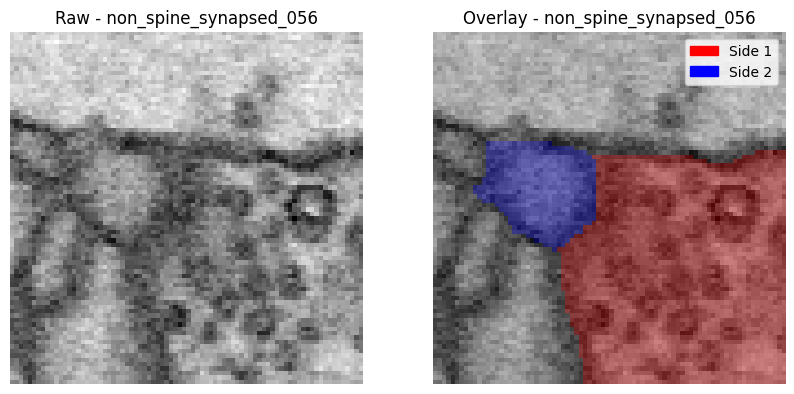

In [3]:
checkpoint_url="https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
!wget -O hemibrain_production.checkpoint "$checkpoint_url"
!pip install git+https://github.com/funkelab/funlib.learn.torch.git
!pip install openpyxl
import torch
from funlib.learn.torch.models import Vgg3D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model
checkpoint_url="https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
if not os.path.exists('hemibrain_production.checkpoint'):
    !wget -O hemibrain_production.checkpoint "$checkpoint_url"

model = Vgg3D(
    input_size=(80, 80, 80),
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7
)

checkpoint = torch.load('hemibrain_production.checkpoint', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

neurotransmitter_types = ['GABA', 'acetylcholine', 'glutamate', 'octopamine', 'serotonin', 'dopamine']
predictions = []

with torch.no_grad():
    for sub_raw, sub_mask_1, sub_mask_2, syn_id in dataloader:
        # sub_raw: (1,80,80,80)
        sub_raw = sub_raw.to(device, dtype=torch.float32)
        sub_raw = sub_raw / 255.0
        sub_raw = sub_raw.unsqueeze(1)  # (B,1,80,80,80)

        output = model(sub_raw)  # (B,7)
        probabilities = torch.softmax(output, dim=1)
        probabilities = probabilities.cpu().numpy()[0]

        if probabilities[6] == 1.0:
            predicted_type = 'no_synapse'
        else:
            predicted_class = np.argmax(probabilities[:6])
            predicted_type = neurotransmitter_types[predicted_class]

        predictions.append({
            'Synapse_ID': syn_id,
            'Prediction': predicted_type
        })

df_predictions = pd.DataFrame(predictions)
print(df_predictions.head())
sub_raw_sample, sub_mask_1_sample, sub_mask_2_sample, syn_id_sample = dataset[0]
slice_idx = 40  # middle slice
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(sub_raw_sample[slice_idx], cmap='gray')
ax[0].set_title(f"Raw - {syn_id_sample}")
ax[0].axis('off')

overlay = np.stack([sub_raw_sample[slice_idx]]*3, axis=-1).astype(float)
overlay[sub_mask_1_sample[slice_idx]] = overlay[sub_mask_1_sample[slice_idx]]*0.7 + np.array([255,0,0])*0.3
overlay[sub_mask_2_sample[slice_idx]] = overlay[sub_mask_2_sample[slice_idx]]*0.7 + np.array([0,0,255])*0.3
overlay = np.clip(overlay,0,255).astype(np.uint8)
ax[1].imshow(overlay)
ax[1].set_title(f"Overlay - {syn_id_sample}")
ax[1].axis('off')

legend_patches = [
    Patch(facecolor='red', edgecolor='red', label='Side 1'),
    Patch(facecolor='blue', edgecolor='blue', label='Side 2')
]
ax[1].legend(handles=legend_patches, loc='upper right', frameon=True)
plt.show()

In [4]:
df_predictions

,Synapse_ID,Prediction
0,"(non_spine_synapsed_056, non_spine_synapse_057)",dopamine
1,"(non_spine_synapse_058, non_spine_synapse_063)",acetylcholine
2,"(non_spine_synapse_062, non_spine_synapse_061)",acetylcholine
3,"(non_spine_synapse_060, non_spine_synapse_059)",octopamine
4,"(non_spine_synapse_054, non_spine_synapse_053)",octopamine
5,"(non_spine_synapse_052, non_spine_synapse_051)",acetylcholine
6,"(non_spine_synapse_050, non_spine_synapse_049)",dopamine
7,"(non_spine_synapse_048, non_spine_synapse_047)",dopamine
8,"(non_spine_synapse_046, non_spine_synapse_045)",dopamine
9,"(non_spine_synapse_044, non_spine_synapse_040)",dopamine


## Grad-cam on Vgg3d

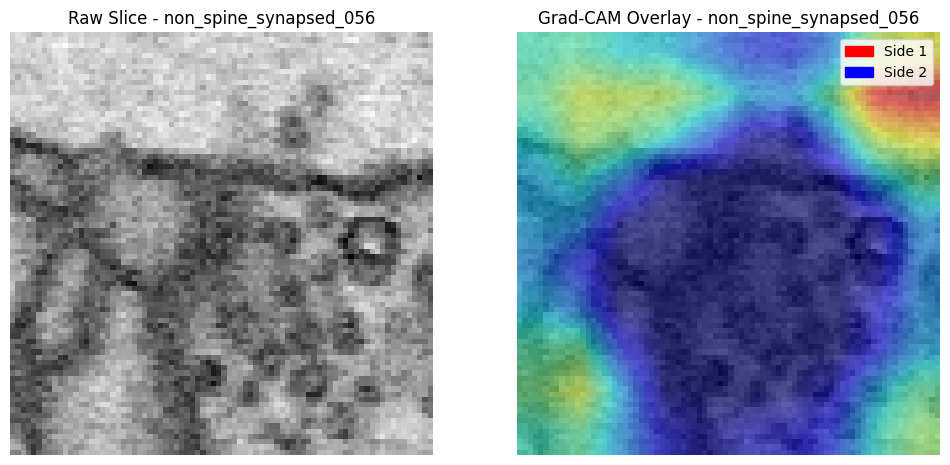

In [6]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Identify the target convolutional layer for Grad-CAM
target_layer_index = None
for idx, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.Conv3d):
        target_layer_index = idx
if target_layer_index is None:
    raise ValueError("No convolutional layer found in model.features")

target_layer = model.features[target_layer_index]

activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations['value'] = output
    # register hook on output to get gradients
    output.register_hook(backward_hook)

def backward_hook(grad):
    gradients['value'] = grad

handle = target_layer.register_forward_hook(forward_hook)

# Take one sample from the dataset
sub_raw, sub_mask_1, sub_mask_2, syn_id = dataset[0]  # just one sample

# Prepare input
input_vol = torch.from_numpy(sub_raw).float().unsqueeze(0).unsqueeze(0).to(device)  # shape (1,1,80,80,80)
input_vol = input_vol / 255.0

model.zero_grad()
output = model(input_vol)  # shape (1,7)
predicted_class = output.argmax(dim=1).item()
score = output[0, predicted_class]
score.backward()

activations_value = activations['value']   # shape (1,C,D',H',W')
gradients_value = gradients['value']       # shape (1,C,D',H',W')

# Global average pooling of gradients
weights = torch.mean(gradients_value, dim=(2, 3, 4), keepdim=True)  # (1,C,1,1,1)
gradcam = torch.sum(weights * activations_value, dim=1, keepdim=True)  # (1,1,D',H',W')
gradcam = F.relu(gradcam)

# Normalize grad-cam
gradcam = gradcam - gradcam.min()
if gradcam.max() > 0:
    gradcam = gradcam / gradcam.max()

# Now gradcam size is smaller than 80x80x80. Let's upsample it:
# gradcam: shape (1,1,D',H',W'), input_vol: (1,1,80,80,80)
desired_shape = (input_vol.shape[2], input_vol.shape[3], input_vol.shape[4])  # (80,80,80)
gradcam_upsampled = F.interpolate(gradcam, size=desired_shape, mode='trilinear', align_corners=False)
gradcam_np = gradcam_upsampled.cpu().detach().numpy()[0,0]  # shape (80,80,80)

# Visualize a central slice
slice_idx = gradcam_np.shape[0] // 2
raw_slice = sub_raw[slice_idx].astype(float)
overlay = np.stack([raw_slice, raw_slice, raw_slice], axis=-1)

# Create a color map from gradcam values
colormap = plt.get_cmap('jet')
gradcam_color = colormap(gradcam_np[slice_idx])
gradcam_color = (gradcam_color[:, :, :3] * 255).astype(np.uint8)  # (80,80,3)

# Blend with raw slice
alpha = 0.5
overlay = (overlay*(1-alpha) + gradcam_color*alpha).astype(np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(sub_raw[slice_idx], cmap='gray')
ax[0].set_title(f"Raw Slice - {syn_id}")
ax[0].axis('off')

ax[1].imshow(overlay)
ax[1].set_title(f"Grad-CAM Overlay - {syn_id}")
ax[1].axis('off')

legend_patches = [
    Patch(facecolor='red', edgecolor='red', label='Side 1'),
    Patch(facecolor='blue', edgecolor='blue', label='Side 2')
]
ax[1].legend(handles=legend_patches, loc='upper right', frameon=True)
plt.show()

# Remove the hook
handle.remove()


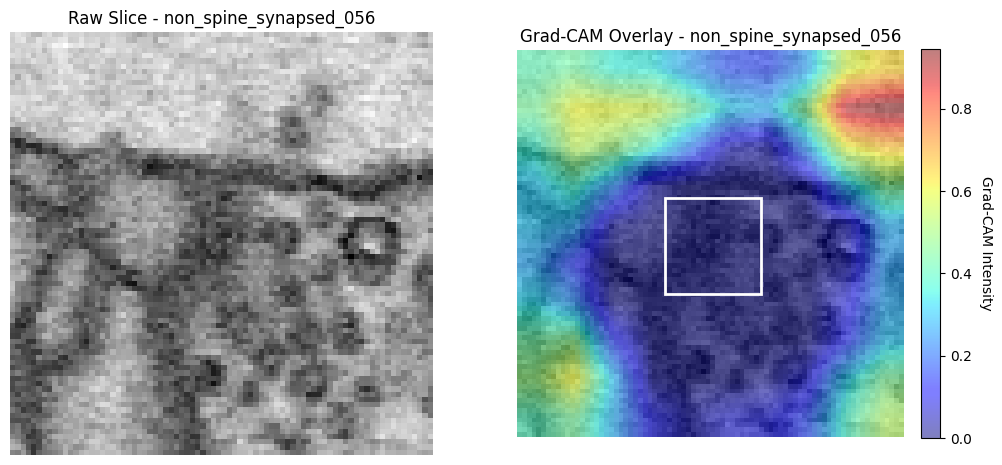

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle

# Assuming model, device, raw_vol, seg_vol, and df are defined, and we have:
# dataset = SynapseDataset(...) which returns sub_raw, sub_mask_1, sub_mask_2, syn_id, central_coord

target_layer_index = None
for idx, layer in enumerate(model.features):
    if isinstance(layer, torch.nn.Conv3d):
        target_layer_index = idx
if target_layer_index is None:
    raise ValueError("No convolutional layer found in model.features")

target_layer = model.features[target_layer_index]

activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations['value'] = output
    output.register_hook(backward_hook)

def backward_hook(grad):
    gradients['value'] = grad

handle = target_layer.register_forward_hook(forward_hook)

sub_raw, sub_mask_1, sub_mask_2, syn_id, central_coord = dataset[0]
cx, cy, cz = central_coord

# When we extracted the subvolume, we computed x_start, y_start, z_start in the dataset.
# The dataset clipped and padded the volume. We need to replicate that logic to find local coords.

# The dataset code:
# z_start = max(cz - half_size, 0)
# y_start = max(cy - half_size, 0)
# x_start = max(cx - half_size, 0)

# Since the dataset returns an 80x80x80 volume always starting at index 0,
# we must recalculate or store these starts. Let's assume we have access to half_size:
half_size = 40
z_start = max(cz - half_size, 0)
y_start = max(cy - half_size, 0)
x_start = max(cx - half_size, 0)

# Now local center coordinates:
cz_local = cz - z_start
cy_local = cy - y_start
cx_local = cx - x_start

# Prepare input for the model
input_vol = torch.from_numpy(sub_raw).float().unsqueeze(0).unsqueeze(0).to(device)
input_vol = input_vol / 255.0

model.zero_grad()
output = model(input_vol)  # shape (1,7)
predicted_class = output.argmax(dim=1).item()
score = output[0, predicted_class]
score.backward()

activations_value = activations['value']
gradients_value = gradients['value']

weights = torch.mean(gradients_value, dim=(2, 3, 4), keepdim=True)
gradcam = torch.sum(weights * activations_value, dim=1, keepdim=True)
gradcam = F.relu(gradcam)

gradcam = gradcam - gradcam.min()
if gradcam.max() > 0:
    gradcam = gradcam / gradcam.max()

desired_shape = (input_vol.shape[2], input_vol.shape[3], input_vol.shape[4])  # (80,80,80)
gradcam_upsampled = F.interpolate(gradcam, size=desired_shape, mode='trilinear', align_corners=False)
gradcam_np = gradcam_upsampled.cpu().detach().numpy()[0,0]

# Use the local z-coordinate for slicing
slice_idx = cz_local
raw_slice = sub_raw[slice_idx].astype(float)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Left: Raw slice
ax[0].imshow(raw_slice, cmap='gray')
ax[0].set_title(f"Raw Slice - {syn_id}")
ax[0].axis('off')

# Right: Grad-CAM overlay
im_heatmap = ax[1].imshow(raw_slice, cmap='gray', alpha=1.0)
im_heatmap = ax[1].imshow(gradcam_np[slice_idx], cmap='jet', alpha=0.5)
ax[1].set_title(f"Grad-CAM Overlay - {syn_id}")
ax[1].axis('off')

# Draw a 20x20 bounding box around the synapse center using local coords
half_box = 10
rect = Rectangle((cx_local - half_box, cy_local - half_box), 20, 20, linewidth=2, edgecolor='white', facecolor='none')
ax[1].add_patch(rect)

# Create a colorbar to represent Grad-CAM intensity
cbar = fig.colorbar(im_heatmap, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_label('Grad-CAM Intensity', rotation=270, labelpad=15)

plt.show()

handle.remove()


In [8]:
dataset[0]

(array([[[157, 112,  78, ..., 100,  73,  79],
         [143, 137, 110, ...,  91,  61,  78],
         [143, 154, 150, ...,  65,  80,  91],
         ...,
         [142, 141, 126, ...,  30,  55,  50],
         [135, 149, 133, ...,  67,  64,  62],
         [134, 125,  93, ...,  87,  74,  46]],
 
        [[149, 163, 125, ..., 111, 126, 116],
         [161, 142, 141, ..., 109, 105,  89],
         [143, 135, 106, ...,  96,  70,  63],
         ...,
         [122, 119, 126, ...,  41,  14,  39],
         [130, 148, 133, ...,  53,  37,  72],
         [123, 126, 112, ...,  73,  58,  53]],
 
        [[155, 128,  99, ..., 118, 124, 108],
         [122, 133, 114, ...,  98,  98, 116],
         [138, 157, 136, ..., 116, 110,  96],
         ...,
         [145, 151, 131, ...,  59,  59,  53],
         [157, 111, 101, ...,  68,  45,  51],
         [133, 122, 116, ...,  66,  66,  92]],
 
        ...,
 
        [[142, 145, 161, ..., 171, 146, 138],
         [156, 159, 129, ..., 154, 146, 156],
         [ 82,

# GMM unsupervised

<ipython-input-11-0559db2edfc4>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  raw_slices = [imageio.imread(f) for f in raw_tif_files]
<ipython-input-11-0559db2edfc4>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  seg_slices = [imageio.imread(f).astype(np.uint32) for f in seg_tif_files]


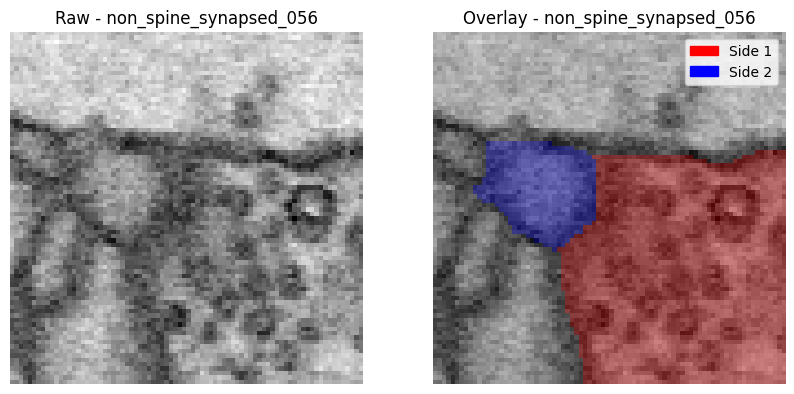

Synapse non_spine_synapsed_056 assigned to cluster 4
Synapse non_spine_synapse_057 assigned to cluster 2
Synapse non_spine_synapse_058 assigned to cluster 2
Synapse non_spine_synapse_063 assigned to cluster 0
Synapse non_spine_synapse_062 assigned to cluster 3
Synapse non_spine_synapse_061 assigned to cluster 3
Synapse non_spine_synapse_060 assigned to cluster 3
Synapse non_spine_synapse_059 assigned to cluster 0
Synapse non_spine_synapse_054 assigned to cluster 2
Synapse non_spine_synapse_053 assigned to cluster 1
Synapse non_spine_synapse_052 assigned to cluster 2
Synapse non_spine_synapse_051 assigned to cluster 2
Synapse non_spine_synapse_050 assigned to cluster 1
Synapse non_spine_synapse_049 assigned to cluster 0
Synapse non_spine_synapse_048 assigned to cluster 1
Synapse non_spine_synapse_047 assigned to cluster 5
Synapse non_spine_synapse_046 assigned to cluster 5
Synapse non_spine_synapse_045 assigned to cluster 3
Synapse non_spine_synapse_044 assigned to cluster 3
Synapse non

In [11]:
import pandas as pd
import os
import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_name = 'bbox1'
excel_file = f'{bbox_name}.xlsx'

def load_bbox_data(bbox_name, max_slices=None):
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), "Raw and segmentation file counts do not match."

    raw_slices = [imageio.imread(f) for f in raw_tif_files]
    seg_slices = [imageio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # shape (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # shape (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

class SynapseDataset(Dataset):
    def __init__(self, raw_vol, seg_vol, synapse_df, subvol_size=80):
        self.raw_vol = raw_vol
        self.seg_vol = seg_vol
        self.synapse_df = synapse_df
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        central_coord = (int(syn_info['central_coord_1']),
                         int(syn_info['central_coord_2']),
                         int(syn_info['central_coord_3']))
        side1_coord = (int(syn_info['side_1_coord_1']),
                       int(syn_info['side_1_coord_2']),
                       int(syn_info['side_1_coord_3']))
        side2_coord = (int(syn_info['side_2_coord_1']),
                       int(syn_info['side_2_coord_2']),
                       int(syn_info['side_2_coord_3']))

        mask_1_full, mask_2_full = create_segment_masks(self.seg_vol, side1_coord, side2_coord)

        cx, cy, cz = central_coord
        x_start = max(cx - self.half_size, 0)
        x_end = min(cx + self.half_size, self.raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end = min(cy + self.half_size, self.raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end = min(cz + self.half_size, self.raw_vol.shape[0])

        sub_raw = self.raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_mask_1 = np.zeros(desired_shape, dtype=bool)
        padded_sub_mask_2 = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_mask_1[:dz, :dy, :dx] = sub_mask_1
        padded_sub_mask_2[:dz, :dy, :dx] = sub_mask_2

        return padded_sub_raw, padded_sub_mask_1, padded_sub_mask_2, syn_info['Var1']

raw_vol, seg_vol = load_bbox_data(bbox_name)
df = pd.read_excel(excel_file)

dataset = SynapseDataset(raw_vol, seg_vol, df, subvol_size=80)
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

batch = next(iter(dataloader))
sub_raw_batch, sub_mask_1_batch, sub_mask_2_batch, names_batch = batch

sub_raw = sub_raw_batch[0].numpy()
sub_mask_1 = sub_mask_1_batch[0].numpy()
sub_mask_2 = sub_mask_2_batch[0].numpy()
name = names_batch[0]

fig, ax = plt.subplots(1,2, figsize=(10,5))
slice_idx = 40  # central slice
ax[0].imshow(sub_raw[slice_idx], cmap='gray')
ax[0].set_title(f"Raw - {name}")
ax[0].axis('off')

overlay = np.stack([sub_raw[slice_idx]]*3, axis=-1).astype(float)
overlay[sub_mask_1[slice_idx]] = overlay[sub_mask_1[slice_idx]]*0.7 + np.array([255,0,0])*0.3
overlay[sub_mask_2[slice_idx]] = overlay[sub_mask_2[slice_idx]]*0.7 + np.array([0,0,255])*0.3
overlay = np.clip(overlay,0,255).astype(np.uint8)
ax[1].imshow(overlay)
ax[1].set_title(f"Overlay - {name}")
ax[1].axis('off')

legend_patches = [
    Patch(facecolor='red', edgecolor='red', label='Side 1'),
    Patch(facecolor='blue', edgecolor='blue', label='Side 2')
]
ax[1].legend(handles=legend_patches, loc='upper right', frameon=True)
plt.show()

# Below is the GMM-based unsupervised classification code

# Extract features for all synapses in the dataset
full_dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
all_features = []
all_ids = []

for sub_raw, sub_mask_1, sub_mask_2, syn_id in full_dataloader:
    sub_raw_np = sub_raw.numpy().astype(np.float32)
    sub_mask_1_np = sub_mask_1.numpy()
    sub_mask_2_np = sub_mask_2.numpy()

    # Extract simple features:
    # 1. Mean intensity of entire subvolume
    # 2. Mean intensity in pre_mask region
    # 3. Mean intensity in post_mask region
    # 4. Intensity at the center slice (assuming center at (40,40,40))
    center_x, center_y, center_z = 40,40,40

    for i in range(sub_raw_np.shape[0]):
        vol = sub_raw_np[i]
        pre_mask = sub_mask_1_np[i]
        post_mask = sub_mask_2_np[i]

        mean_intensity = vol.mean()
        mean_pre = vol[pre_mask].mean() if pre_mask.any() else 0
        mean_post = vol[post_mask].mean() if post_mask.any() else 0
        center_intensity = vol[center_z, center_y, center_x]

        feature_vec = np.array([mean_intensity, mean_pre, mean_post, center_intensity], dtype=np.float32)
        all_features.append(feature_vec)
        all_ids.append(syn_id[i])

all_features = np.array(all_features)  # shape (N,4)

# Perform GMM clustering on these features
num_clusters = 7
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(all_features)

# Print cluster assignments
for syn_id, label in zip(all_ids, gmm_labels):
    print(f"Synapse {syn_id} assigned to cluster {label}")


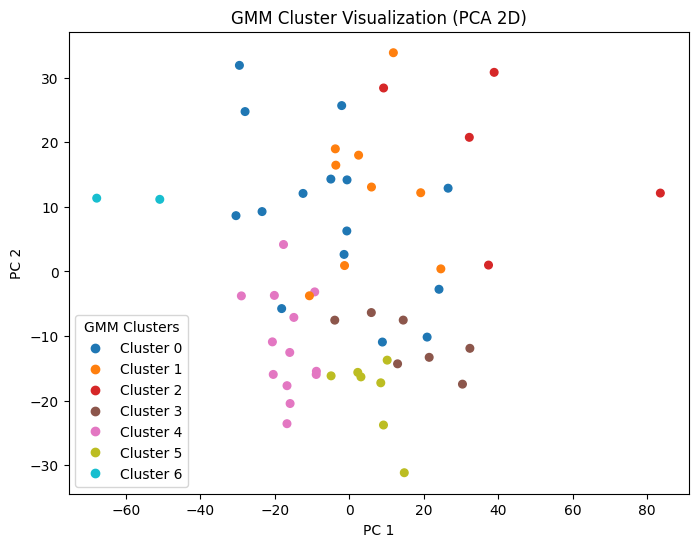

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


pca_vis = PCA(n_components=2)
X_2d = pca_vis.fit_transform(all_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=gmm_labels, cmap='tab10', s=30)

unique_labels = np.unique(gmm_labels)
handles = []
for lbl in unique_labels:
    handles.append(plt.Line2D([], [], marker='o', linestyle='',
                              color=scatter.cmap(scatter.norm(lbl)),
                              label=f'Cluster {lbl}'))
plt.legend(handles=handles, loc='best', title='GMM Clusters')

plt.title('GMM Cluster Visualization (PCA 2D)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


# Combine ViT and DBscan

Input shape: torch.Size([2, 1, 80, 80, 80])
Output shape: torch.Size([2, 2])
Labels: ('non_spine_synapse_014', 'non_spine_synapse_013')
Feature map shape: torch.Size([8, 256])


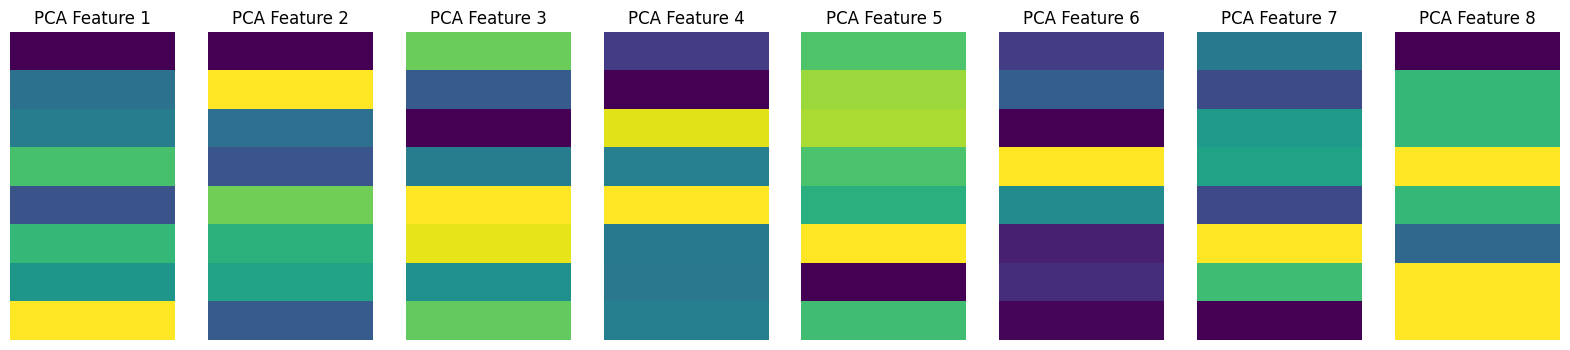

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader
import numpy as np
import imageio.v2 as imageio
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


class ViT_VNet_Synapse(nn.Module):
    def __init__(self, img_size=80, patch_size=8, in_channels=1, num_classes=2,
                 embed_dim=256, num_heads=8, depth=4):
        super(ViT_VNet_Synapse, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(32), nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(64), nn.ReLU(),
            nn.Conv3d(64, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(embed_dim), nn.ReLU()
        )

        self.patch_embed = nn.Linear(patch_size**3 * embed_dim, embed_dim)

        self.position_embed = None

        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.feature_maps = []
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(module, input, output):
            self.feature_maps.append(output.detach().cpu())
        for i, layer in enumerate(self.transformer):
            layer.register_forward_hook(hook_fn)

    def forward(self, x):
        self.feature_maps = []
        x = self.encoder(x)
        B, C, D, H, W = x.shape

        pad_d = (self.patch_size - D % self.patch_size) % self.patch_size
        pad_h = (self.patch_size - H % self.patch_size) % self.patch_size
        pad_w = (self.patch_size - W % self.patch_size) % self.patch_size

        x = F.pad(x, (0, pad_w, 0, pad_h, 0, pad_d), mode='constant', value=0)
        D, H, W = x.shape[2], x.shape[3], x.shape[4]

        # Flatten into patches
        x = rearrange(x, 'b c (d p1) (h p2) (w p3) -> b (d h w) (p1 p2 p3 c)',
                      p1=self.patch_size, p2=self.patch_size, p3=self.patch_size)
        x = self.patch_embed(x)  # Shape: [B, num_patches, embed_dim]

        # Dynamically initialize positional embedding
        num_patches = x.shape[1]
        if self.position_embed is None or self.position_embed.shape[1] != num_patches:
            self.position_embed = nn.Parameter(torch.zeros(1, num_patches, self.embed_dim, device=x.device))
            nn.init.trunc_normal_(self.position_embed, std=0.02)

        x += self.position_embed

        # Transformer
        for layer in self.transformer:
            x = layer(x)

        x = x.mean(dim=1)  # Shape: [B, embed_dim]
        x = self.classifier(x)
        return x


def load_bbox_data(bbox_name, max_slices=None):
    raw_base_dir = '/content/raw'
    seg_base_dir = '/content/seg'
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), "Raw and segmentation file counts do not match."

    raw_slices = [imageio.imread(f) for f in raw_tif_files]
    seg_slices = [imageio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)
    seg_vol = np.stack(seg_slices, axis=0)
    return raw_vol, seg_vol

if __name__ == "__main__":
    # Load Data
    raw_vol, seg_vol = load_bbox_data('bbox1')
    df = pd.read_excel('bbox1.xlsx')

    dataset = SynapseDatasetLoader(raw_vol, seg_vol, df, subvol_size=80)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    # Model
    model = ViT_VNet_Synapse(img_size=80, patch_size=8, in_channels=1, num_classes=2)

    for batch in dataloader:
        sub_vols, labels = batch
        outputs = model(sub_vols)
        print("Input shape:", sub_vols.shape)
        print("Output shape:", outputs.shape)
        print("Labels:", labels)

        feature_map = model.feature_maps[0][0]
        print("Feature map shape:", feature_map.shape)

        pca = PCA(n_components=8)
        reduced_feature_map = pca.fit_transform(feature_map.numpy())

        fig, axes = plt.subplots(1, reduced_feature_map.shape[1], figsize=(20, 4))
        for i in range(reduced_feature_map.shape[1]):
            axes[i].imshow(reduced_feature_map[:, i].reshape(-1, 1), aspect='auto', cmap='viridis')
            axes[i].set_title(f"PCA Feature {i+1}")
            axes[i].axis('off')
        plt.show()
        break


Input shape: torch.Size([1, 1, 80, 80, 80])
Output shape: torch.Size([1, 2])
Predicted Class: 0 | Label: ('non_spine_synapse_017',)
Attention weights shape: torch.Size([8, 8])


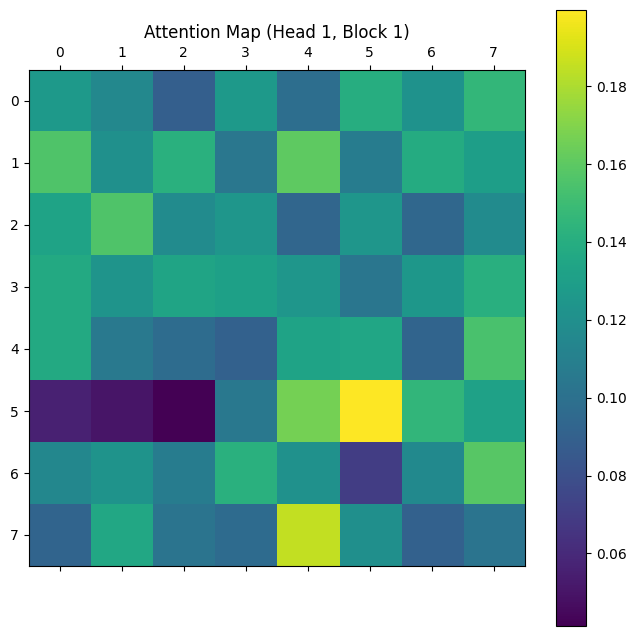

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torch.utils.data import DataLoader
import numpy as np
import imageio.v2 as imageio
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
        self.attn_weights = None
    def forward(self, x):
        attn_output, attn_weights = self.attn(self.norm1(x), self.norm1(x), self.norm1(x), need_weights=True)
        self.attn_weights = attn_weights.detach().cpu()
        x = x + attn_output
        x = x + self.mlp(self.norm2(x))
        return x


class ViT_VNet_Synapse(nn.Module):
    def __init__(self, img_size=80, patch_size=8, in_channels=1, num_classes=2,
                 embed_dim=256, num_heads=8, depth=4):
        super(ViT_VNet_Synapse, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(32), nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(64), nn.ReLU(),
            nn.Conv3d(64, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(embed_dim), nn.ReLU()
        )

        self.patch_embed = nn.Linear(patch_size**3 * embed_dim, embed_dim)

        self.position_embed = None

        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ])

        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

        self.attn_weights = []

    def forward(self, x):
        self.attn_weights = []
        x = self.encoder(x)
        B, C, D, H, W = x.shape

        pad_d = (self.patch_size - D % self.patch_size) % self.patch_size
        pad_h = (self.patch_size - H % self.patch_size) % self.patch_size
        pad_w = (self.patch_size - W % self.patch_size) % self.patch_size

        x = F.pad(x, (0, pad_w, 0, pad_h, 0, pad_d), mode='constant', value=0)
        D, H, W = x.shape[2], x.shape[3], x.shape[4]

        x = rearrange(x, 'b c (d p1) (h p2) (w p3) -> b (d h w) (p1 p2 p3 c)',
                      p1=self.patch_size, p2=self.patch_size, p3=self.patch_size)
        x = self.patch_embed(x)
        num_patches = x.shape[1]
        if self.position_embed is None or self.position_embed.shape[1] != num_patches:
            self.position_embed = nn.Parameter(torch.zeros(1, num_patches, self.embed_dim, device=x.device))
            nn.init.trunc_normal_(self.position_embed, std=0.02)

        x += self.position_embed

        # Transformer
        for layer in self.transformer:
            x = layer(x)
            self.attn_weights.append(layer.attn_weights)

        x = x.mean(dim=1)
        x = self.classifier(x)
        return x


def load_bbox_data(bbox_name, max_slices=None):
    raw_base_dir = '/content/raw'
    seg_base_dir = '/content/seg'
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), "Raw and segmentation file counts do not match."

    raw_slices = [imageio.imread(f) for f in raw_tif_files]
    seg_slices = [imageio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # shape (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # shape (Z, Y, X)
    return raw_vol, seg_vol

if __name__ == "__main__":
    raw_vol, seg_vol = load_bbox_data('bbox1')
    df = pd.read_excel('bbox1.xlsx')

    dataset = SynapseDatasetLoader(raw_vol, seg_vol, df, subvol_size=80)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    model = ViT_VNet_Synapse(img_size=80, patch_size=8, in_channels=1, num_classes=2)

    for batch in dataloader:
        sub_vols, labels = batch
        outputs = model(sub_vols)
        print("Input shape:", sub_vols.shape)
        print("Output shape:", outputs.shape)
        print("Predicted Class:", outputs.argmax(dim=1).item(), "| Label:", labels)

        attn_weights = model.attn_weights[0][0]
        print("Attention weights shape:", attn_weights.shape)

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        cax = ax.matshow(attn_weights, cmap='viridis')
        fig.colorbar(cax)
        ax.set_title("Attention Map (Head 1, Block 1)")
        plt.show()
        break
